In [1]:
# !conda list dolfin
# !conda list mshr

In [2]:
from dolfin import *
import numpy as np
# import pygad
import pyswarms as ps
import matplotlib.pyplot as plt
import mshr as mr

set_log_level(50)

vertex number: 1167
cell number: 2107


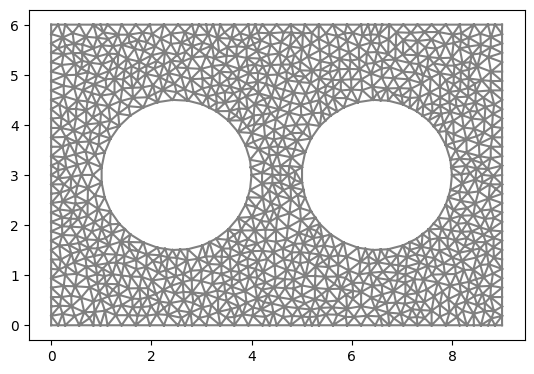

In [3]:
# 创建网格
rectangle = mr.Rectangle(Point(0.0, 0.0), Point(9.0, 6.0))
circle1 = mr.Circle(Point(2.5, 3.0), 1.5)
circle2 = mr.Circle(Point(6.5, 3.0), 1.5)
domain = rectangle - circle1 - circle2  

# 创建网格
mymesh = mr.generate_mesh(domain, 32)
vertex_num = mymesh.num_vertices()
cell_num = mymesh.num_cells()
plot(mymesh)
print(f"vertex number: {vertex_num}")
print(f"cell number: {cell_num}")

In [4]:
# 初始化
"""初始化"""
# 二维正交各向异性
E1, E2, mu12, G12 = 130000, 7700, 0.33, 4800
# 转动角度
Theta = 0
Theta_init = 5
# 载荷
forcing = Constant((500, 0))

# 弹性张量
C2D_Iso = np.array([
    [E1/(1-mu12**2),        mu12*E2/(1-mu12**2),         0  ],
    [mu12*E2/(1-mu12**2),   E2/(1-mu12**2),              0  ],
    [0,                     0,                           G12]
])

# 转轴公式
def T2D_inv(theta):
    theta = theta * np.pi / 180.0
    c = cos(theta)
    s = sin(theta)
    Trans = np.array([
        [c**2,  s**2,   -2*s*c],
        [s**2,  c**2,   2*s*c],
        [s*c,   -s*c,   c**2 - s**2]
    ])
    return Trans

# 准备网格
V = VectorFunctionSpace(mymesh, "CG", 1)
T = FunctionSpace(mymesh, "DG", 0)
u_sol = Function(V)
Theta_sol = Function(T)
u_trial = TrialFunction(V)
v_test = TestFunction(V)

In [5]:
# 定义物理方程
# 物理方程
def epsilon(u):
    engineering_strain = 0.5 * (nabla_grad(u) + nabla_grad(u).T)
    return engineering_strain

# 本构方程
def sigma_tensor(u, Theta_Ev):
    # 计算应变张量
    epsilon_ij = epsilon(u)
    ep = as_vector([epsilon_ij[0,0], epsilon_ij[1,1], epsilon_ij[0,1]])
    # 使用弹性系数计算应力张量
    Q_bar = np.dot(np.dot(T2D_inv(Theta_Ev), C2D_Iso), T2D_inv(Theta_Ev).T)
    sigma_ij = np.dot(Q_bar, ep)

    return as_tensor([[sigma_ij[0], sigma_ij[2]],
                      [sigma_ij[2], sigma_ij[1]]])

# 弹性能密度
def psi(u, Theta):
    return 0.5 * inner(sigma_tensor(u, Theta), epsilon(u))

In [6]:
# 定义边界
# 狄利克雷边界
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < DOLFIN_EPS
bc = DirichletBC(V, Constant((0.0, 0.0)), clamped_boundary)

# 自然边界
class RightEnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 9) < DOLFIN_EPS 
right_end_boundary = RightEnd()

boundary_mark = MeshFunction("size_t", mymesh, mymesh.topology().dim()-1)
boundary_mark.set_all(0)
right_end_boundary.mark(boundary_mark, 1)

In [7]:
# 有限元求解
def FEA(lhs, rhs, u:Function, bc:DirichletBC) -> Function: 
    problem = LinearVariationalProblem(lhs, rhs, u, bc)
    solver = LinearVariationalSolver(problem)
    return solver.solve()

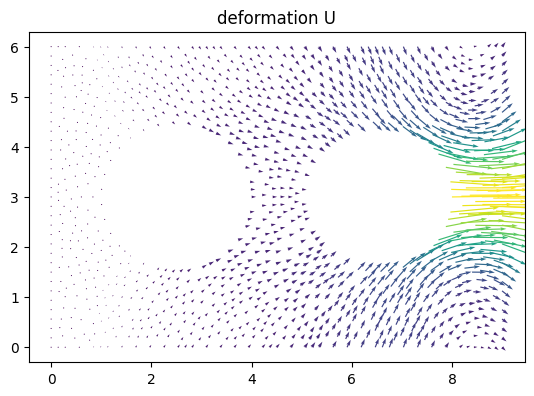

In [8]:
# 有限元计算
theta = 0 * np.ones(T.dim())
theta_init = Function(T)
theta_init.vector()[:] = theta
lhs = inner(sigma_tensor(u_trial, theta_init), nabla_grad(v_test)) * dx
rhs = dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mymesh, subdomain_id=1)
FEA(lhs, rhs, u_sol ,bc=[bc])
plot(u_sol, title="deformation U")

Max Principal Stress Values: [504.31733639 458.24608166 491.12444381 ... 805.795439   859.6862954
 961.1765077 ]
Max Principal Direction Values: [ 0.9997483  -0.02243517  0.99945329 ... -0.01967084  0.99948903
 -0.03196368]


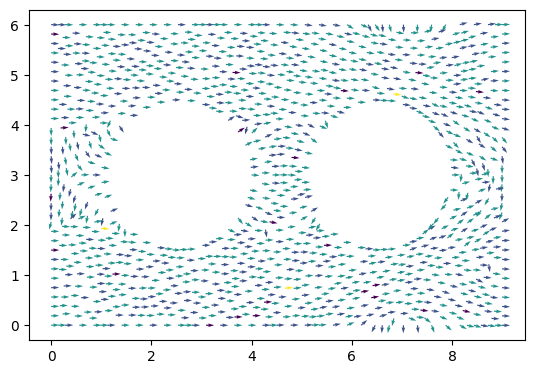

In [9]:
# 计算最大主应力场
stress = sigma_tensor(u_sol, theta_init)
# 创建一个张量函数空间来存储应力场
V_ten = TensorFunctionSpace(mymesh, 'CG', 1)
stress_func = Function(V_ten)

stress_func.assign(project(stress, V_ten))

# 定义函数空间
V_max_principal = FunctionSpace(mymesh, 'CG', 1)
V_vec = VectorFunctionSpace(mymesh, 'CG', 1)

# 定义最大主应力函数和方向函数
max_principal_stress = Function(V_max_principal)
max_principal_direction = Function(V_vec)

# 提取应力值
stress_values = stress_func.vector().get_local().reshape((-1, 2, 2))

# 获取本地向量大小
local_size_stress = max_principal_stress.vector().local_size()
local_size_direction = max_principal_direction.vector().local_size()

# 初始化最大主应力和方向数组
max_principal_stress_values = np.zeros(local_size_stress)
max_principal_direction_values = np.zeros((local_size_direction // 2, 2))  # 确保方向是2维

# 计算最大主应力和方向
for i, stress_tensor in enumerate(stress_values):
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    max_index = np.argmax(eigenvalues)
    max_principal_stress_values[i] = eigenvalues[max_index]
    max_principal_direction_values[i] = eigenvectors[:, max_index]

# 将最大主应力值和方向赋值给相应的函数
max_principal_stress.vector().set_local(max_principal_stress_values)
max_principal_direction.vector().set_local(max_principal_direction_values.flatten())

# 打印最大主应力值和方向
print("Max Principal Stress Values:", max_principal_stress.vector().get_local())
print("Max Principal Direction Values:", max_principal_direction.vector().get_local())
plot(max_principal_direction)

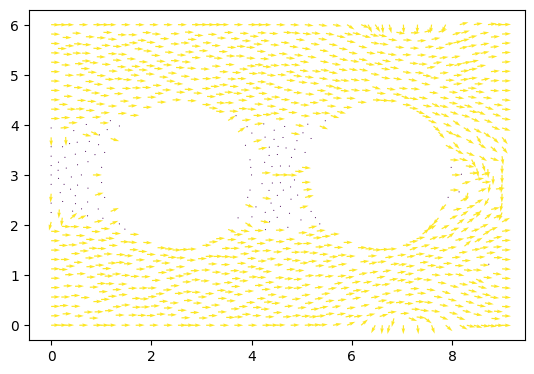

In [10]:
# 计算拉应力场和压应力场
stress = sigma_tensor(u_sol, theta_init)

# 创建一个张量函数空间来存储应力场
V_ten = TensorFunctionSpace(mymesh, 'CG', 1)
stress_func = Function(V_ten)

stress_func.assign(project(stress, V_ten))

# 定义函数空间
V_scalar = FunctionSpace(mymesh, 'CG', 1)
V_vec = VectorFunctionSpace(mymesh, 'CG', 1)

# 定义拉应力和压应力函数及其方向函数
tensile_stress = Function(V_scalar)
compressive_stress = Function(V_scalar)
tensile_direction = Function(V_vec)
compressive_direction = Function(V_vec)

# 提取应力值
stress_values = stress_func.vector().get_local().reshape((-1, 2, 2))

# 获取本地向量大小
local_size_stress = tensile_stress.vector().local_size()
local_size_direction = tensile_direction.vector().local_size()

# 初始化拉应力和压应力及其方向数组
tensile_stress_values = np.zeros(local_size_stress)
compressive_stress_values = np.zeros(local_size_stress)
tensile_direction_values = np.zeros((local_size_direction // 2, 2))  # 确保方向是2维
compressive_direction_values = np.zeros((local_size_direction // 2, 2))  # 确保方向是2维

# 计算拉应力和压应力及其方向
for i, stress_tensor in enumerate(stress_values):
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    
    # 分别获取拉应力和压应力及其方向
    tensile_eigenvalues = eigenvalues[eigenvalues > 0]
    compressive_eigenvalues = eigenvalues[eigenvalues < 0]
    
    if len(tensile_eigenvalues) > 0:
        max_tensile_index = np.argmax(tensile_eigenvalues)
        tensile_stress_values[i] = tensile_eigenvalues[max_tensile_index]
        tensile_direction_values[i] = eigenvectors[:, eigenvalues == tensile_eigenvalues[max_tensile_index]].flatten()
    else:
        tensile_stress_values[i] = 0
        tensile_direction_values[i] = [0, 0]
    
    if len(compressive_eigenvalues) > 0:
        max_compressive_index = np.argmin(compressive_eigenvalues)
        compressive_stress_values[i] = compressive_eigenvalues[max_compressive_index]
        compressive_direction_values[i] = eigenvectors[:, eigenvalues == compressive_eigenvalues[max_compressive_index]].flatten()
    else:
        compressive_stress_values[i] = 0
        compressive_direction_values[i] = [0, 0]

# 将拉应力和压应力值及其方向赋值给相应的函数
tensile_stress.vector().set_local(tensile_stress_values)
compressive_stress.vector().set_local(compressive_stress_values)
tensile_direction.vector().set_local(tensile_direction_values.flatten())
compressive_direction.vector().set_local(compressive_direction_values.flatten())

# 绘制拉应力方向场
plot(tensile_direction)
# 绘制压应力方向场
# plot(compressive_direction)

In [11]:
# 可视化
def plot_theta_vector(theta:Function, mesh, scale=30, width=0.001, title="Vector field"):
    theta_rad = np.deg2rad(Theta_sol.vector()[:])  # 将角度转换为弧度
    x_values = np.cos(theta_rad)
    y_values = np.sin(theta_rad)
    # 将二维向量表示合并为一个二维数组
    vector_values = np.vstack((x_values, y_values)).T  # 转置使每行是一个向量
    # 获取网格的中心点
    cell_midpoints = [cell.midpoint() for cell in cells(mesh)]
    # 提取中心点的坐标
    x_coords = np.array([p.x() for p in cell_midpoints])
    y_coords = np.array([p.y() for p in cell_midpoints])
    u = vector_values[:, 0]
    v = vector_values[:, 1]
    # 可视化向量场
    plt.figure()
    # plot(mesh)
    # plt.quiver(x_coords, y_coords, u, v)
    # 绘制正方向的箭头
    plt.quiver(x_coords, y_coords, u, v, angles='xy', scale_units='xy', scale=scale, width=width, color='b')
    # 绘制反方向的箭头
    plt.quiver(x_coords, y_coords, -u, -v, angles='xy', scale_units='xy', scale=scale, width=width, color='b')

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

In [12]:
# 定义计算总能量的函数
def compute_total_energy(theta_values):
    theta_func = Function(T)
    theta_func.vector()[:] = theta_values
    Theta_sol.assign(theta_func)

    # 定义问题
    lhs = inner(sigma_tensor(u_trial, Theta_sol), nabla_grad(v_test)) * dx
    rhs = dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mymesh, subdomain_id=1)
    
    # 求解
    FEA(lhs, rhs, u_sol, bc)
    
    # 计算总能量
    energy_density = psi(u_sol, Theta_sol) * dx
    total_energy = assemble(energy_density)
    
    return total_energy

def compute_energy_derivative(theta_values:np.array):
    theta_func = Function(T)
    theta_func.vector()[:] = theta_values
    Theta_sol.assign(theta_func)

    # 定义问题
    lhs = inner(sigma_tensor(u_trial, Theta_sol), nabla_grad(v_test)) * dx
    rhs = dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mymesh, subdomain_id=1)
    
    # 求解
    FEA(lhs, rhs, u_sol, bc)
    
    # 计算总能量
    energy_density = psi(u_sol, Theta_sol) * dx
    
    # 计算能量密度对theta的导数
    d_energy_dtheta = derivative(energy_density, Theta_sol, TestFunction(T))
    
    # 将其作为函数输出
    d_energy_dtheta_func = Function(T)
    assemble(d_energy_dtheta, tensor=d_energy_dtheta_func.vector())
    
    return d_energy_dtheta_func.vector().get_local()


In [13]:
import numpy as np

# Adam优化器实现
def adam_optimizer(theta_init, objective, gradient, learning_rate=-0.1, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iters=5000):
    theta = np.copy(theta_init)
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    t = 0
    energy_history = []

    for i in range(max_iters):
        t += 1
        g = gradient(theta)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        
        theta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        energy = objective(theta)
        energy_history.append(energy)

        if i % 100 == 0:
            print(f"Iteration {i}, Energy: {objective(theta)}")
    
    return theta, energy_history

# 使用Adam优化器最小化能量
theta_init = 0 * np.ones(T.dim())
optimized_theta, energy_history = adam_optimizer(theta_init, 
                                                 objective=compute_total_energy, 
                                                 gradient=compute_energy_derivative, 
                                                 learning_rate=-0.1, 
                                                 max_iters=10000)

# 输出最终结果
print("Optimized Theta Values:", optimized_theta)

# 可视化优化后的theta
theta_function = Function(T)
theta_function.vector()[:] = optimized_theta
# plot_theta_vector(theta_function)

Iteration 0, Energy: 226.54798885826136
Iteration 100, Energy: 156.74754398512073
Iteration 200, Energy: 132.85242263136945
Iteration 300, Energy: 122.42366362991547
Iteration 400, Energy: 118.0916439355257
Iteration 500, Energy: 116.36295030070924
Iteration 600, Energy: 115.31160655999008
Iteration 700, Energy: 114.41916916489419
Iteration 800, Energy: 113.6553344115131
Iteration 900, Energy: 113.21364160575568
Iteration 1000, Energy: 112.562135626321
Iteration 1100, Energy: 111.73526223307296
Iteration 1200, Energy: 110.02260009057001
Iteration 1300, Energy: 109.44900087902396
Iteration 1400, Energy: 109.14226621408292
Iteration 1500, Energy: 108.93213452328983
Iteration 1600, Energy: 108.75236866147597
Iteration 1700, Energy: 108.6239774105528
Iteration 1800, Energy: 108.51672832170458
Iteration 1900, Energy: 108.43590138773659
Iteration 2000, Energy: 108.39964029631382
Iteration 2100, Energy: 108.38640782377577
Iteration 2200, Energy: 108.38047349451205
Iteration 2300, Energy: 108.

File 'output/theta_vector(adam).txt' created successfully.


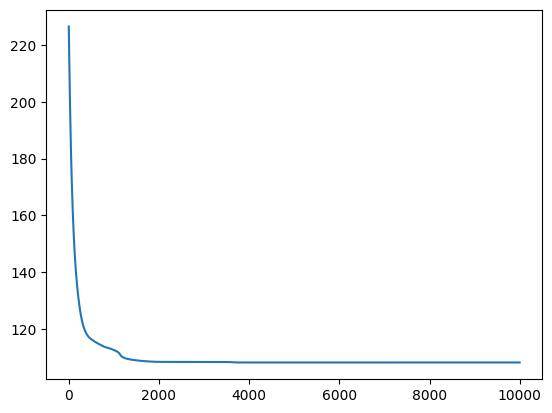

In [14]:
plt.plot(energy_history)
import save_data
save_data.save_vector_field_to_txt(mymesh, theta_function, filename="output/theta_vector(adam).txt")

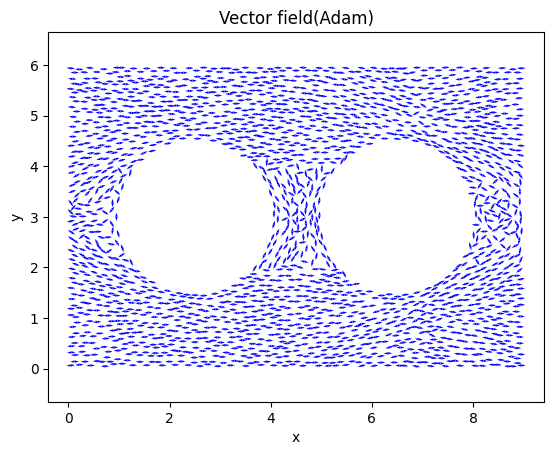

In [15]:
plot_theta_vector(theta_function, mesh=mymesh, scale=12, width=0.0018, title="Vector field(Adam)")

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# SGD优化器实现（带有小批量）
def sgd_optimizer(theta_init, objective, gradient, learning_rate=-0.1, max_iters=1000, batch_size=10):
    theta = np.copy(theta_init)
    energy_history = []
    num_elements = len(theta)

    for i in range(max_iters):
        # 随机选择一个小批量
        indices = np.random.choice(num_elements, batch_size, replace=False)
        
        # 计算当前小批量的梯度
        g = gradient(theta)
        g_batch = np.zeros_like(theta)
        g_batch[indices] = g[indices]
        
        # 更新参数
        theta -= learning_rate * g_batch
        
        # 计算当前的总能量
        energy = objective(theta)
        energy_history.append(energy)
        
        if i % 100 == 0:
            print(f"Iteration {i}, Energy: {energy}")
    
    return theta, energy_history

# 使用SGD优化器最小化能量
theta_init = 0 * np.ones(T.dim())
optimized_theta, energy_history = sgd_optimizer(theta_init,
                                                objective=compute_total_energy,
                                                gradient=compute_energy_derivative, 
                                                learning_rate=-2, 
                                                max_iters=50000, 
                                                batch_size=200)

# 输出最终结果
print("Optimized Theta Values:", optimized_theta)


Iteration 0, Energy: 227.5782086051863
Iteration 100, Energy: 220.04947317054075
Iteration 200, Energy: 213.15115729056785
Iteration 300, Energy: 207.61051051858837
Iteration 400, Energy: 202.53651633237334
Iteration 500, Energy: 198.18856586629568
Iteration 600, Energy: 194.24720160001849
Iteration 700, Energy: 190.50636040407528
Iteration 800, Energy: 186.98353394977445
Iteration 900, Energy: 184.04803629689818
Iteration 1000, Energy: 181.28442946381767
Iteration 1100, Energy: 178.78286346756258
Iteration 1200, Energy: 176.46175502936666
Iteration 1300, Energy: 174.40786481266105
Iteration 1400, Energy: 172.44280741293053
Iteration 1500, Energy: 170.5768557237779
Iteration 1600, Energy: 168.82819646157358
Iteration 1700, Energy: 167.1233617719757
Iteration 1800, Energy: 165.65233127469236
Iteration 1900, Energy: 164.16724179242044
Iteration 2000, Energy: 162.87400988938728
Iteration 2100, Energy: 161.57865761950038
Iteration 2200, Energy: 160.40413190918454
Iteration 2300, Energy: 15

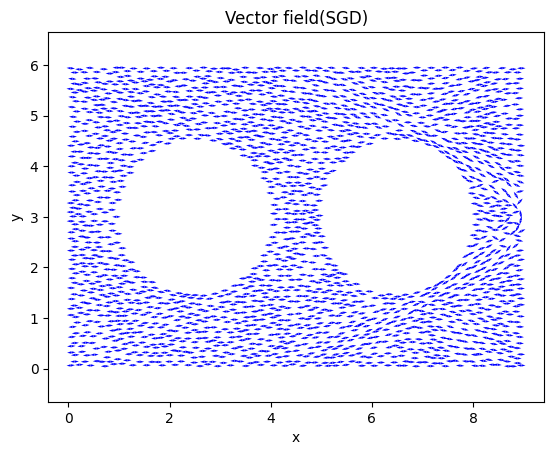

File 'output/theta_vector(SGD).txt' created successfully.


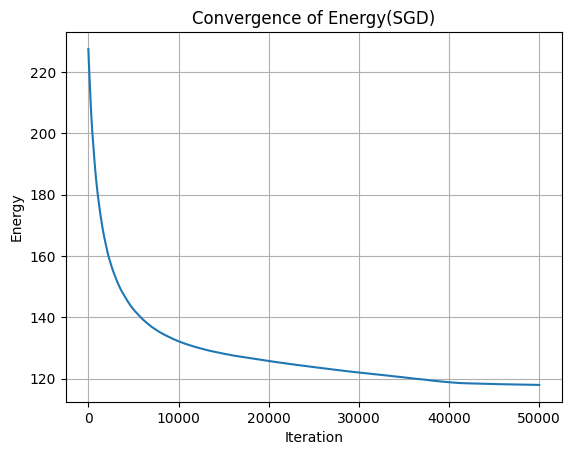

In [17]:
# 可视化优化后的theta
theta_function = Function(T)
theta_function.vector()[:] = optimized_theta

plot_theta_vector(theta_function, mesh=mymesh, scale=12, width=0.0018, title="Vector field(SGD)")
save_data.save_vector_field_to_txt(mymesh, theta_function, filename="output/theta_vector(SGD).txt")

# 绘制能量随迭代次数的变化图
plt.figure()
plt.plot(energy_history)
plt.title("Convergence of Energy(SGD)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.grid(True)
plt.show()

NameError: name 'energy_history_sgd' is not defined

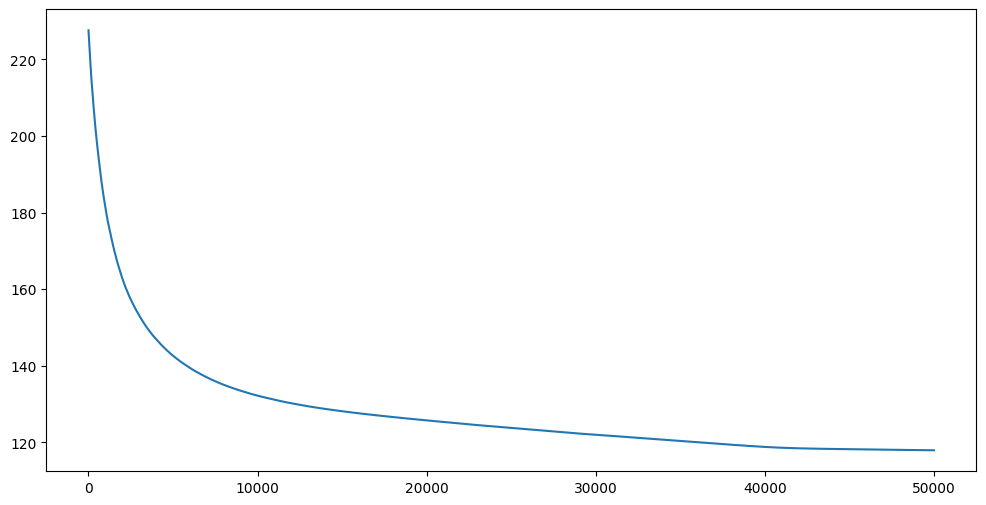

In [18]:
# 对比Adam和SGD优化器的收敛情况

# 使用之前的数据，不重新创建优化器

# 绘制对比图
plt.figure(figsize=(12, 6))
plt.plot(energy_history, label='Adam')  # 假设energy_history是Adam优化器的结果
plt.plot(energy_history_sgd, label='SGD')  # 假设energy_history_sgd是SGD优化器的结果
plt.title("收敛对比：Adam vs SGD")
plt.xlabel("迭代次数")
plt.ylabel("能量")
plt.legend()
plt.grid(True)
plt.show()

# 输出最终能量值
print(f"Adam最终能量: {energy_history[-1]}")
print(f"SGD最终能量: {energy_history_sgd[-1]}")

# 计算收敛速度（以达到最终能量的95%为标准）
final_energy_adam = energy_history[-1]
final_energy_sgd = energy_history_sgd[-1]

convergence_threshold_adam = final_energy_adam * 1.05
convergence_threshold_sgd = final_energy_sgd * 1.05

convergence_iteration_adam = next(i for i, e in enumerate(energy_history) if e <= convergence_threshold_adam)
convergence_iteration_sgd = next(i for i, e in enumerate(energy_history_sgd) if e <= convergence_threshold_sgd)

print(f"Adam收敛迭代次数: {convergence_iteration_adam}")
print(f"SGD收敛迭代次数: {convergence_iteration_sgd}")


